In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score as ROC 
from sklearn.metrics import recall_score as Recall 
from sklearn.metrics import precision_score as Precision

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as TTS 

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression as LogiR
from sklearn.linear_model import LinearRegression as LR

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR



from collections import Counter

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

In [2]:
df_raw = pd.read_csv("card_transdata.csv")
df_raw.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
df_raw.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


# Distribution


In [4]:
cols_numerical_features = ["distance_from_home",	"distance_from_last_transaction",	"ratio_to_median_purchase_price"]
cols_bin = ["repeat_retailer",	"used_chip",	"used_pin_number",	"online_order"]

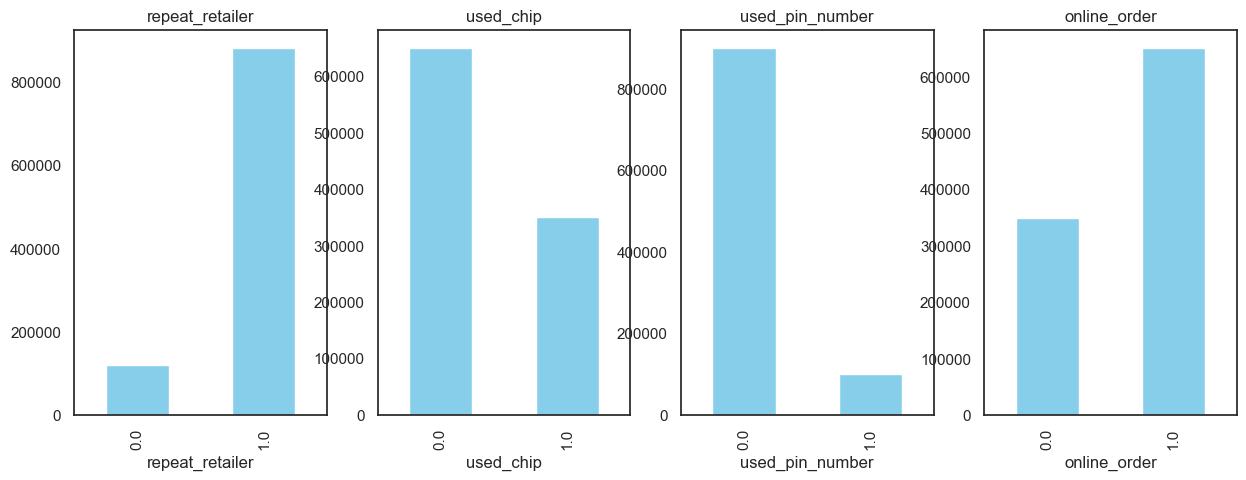

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(cols_bin), figsize=(15, 5))

for i, col in enumerate(cols_bin):
    df_raw[col].value_counts().sort_index().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(col)

plt.show()

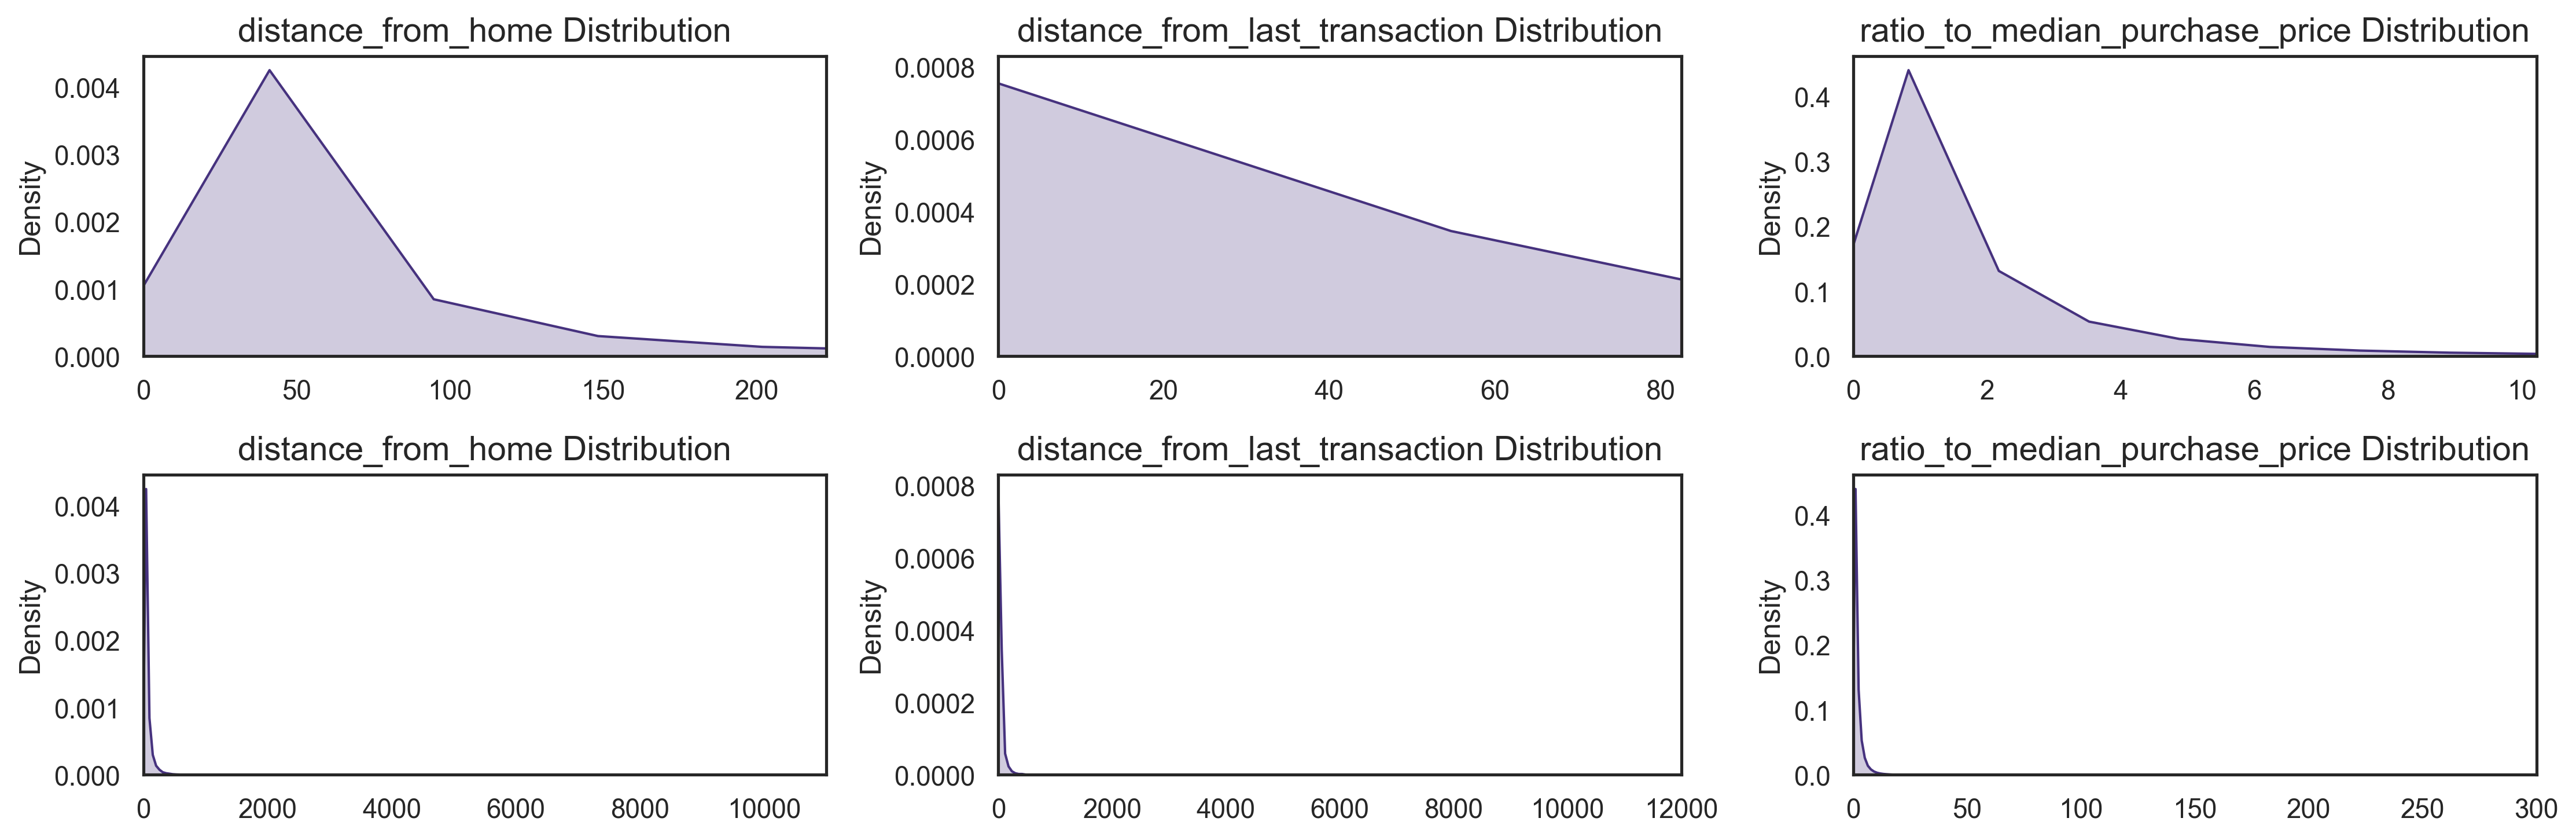

In [6]:
fig, ax = plt.subplots(2, 3, figsize = (15, 5), dpi = 300)
ax = ax.flatten()
fig.tight_layout()
x_limits = [
    (0, df_raw['distance_from_home'].mean() + 3 * df_raw['distance_from_home'].std()),
    (0, df_raw['distance_from_last_transaction'].mean() + 3 * df_raw['distance_from_last_transaction'].std()),
    (0, df_raw['ratio_to_median_purchase_price'].mean() + 3 * df_raw['ratio_to_median_purchase_price'].std())
]
for i, column in enumerate(cols_numerical_features):
    sns.kdeplot(df_raw[column], ax=ax[i], color=pal[0], fill = True)
    ax[i].set_xlim(x_limits[i])
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)

x_limits = [(0, 11000), (0, 12000), (0, 300)]
for i, column in enumerate(cols_numerical_features):
    j = i + 3
    sns.kdeplot(df_raw[column], ax=ax[j], color=pal[0], fill = True)
    ax[j].set_xlim(x_limits[i])
    ax[j].set_title(f'{column} Distribution', size = 14)
    ax[j].set_xlabel(None)

plt.tight_layout()

It is very imbalance, let's check the extrem values


distance_from_home


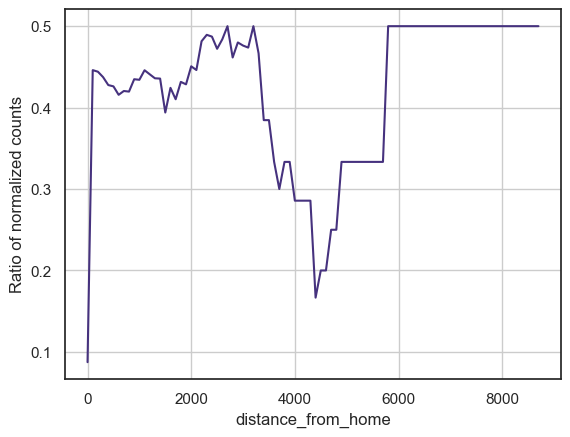

distance_from_last_transaction


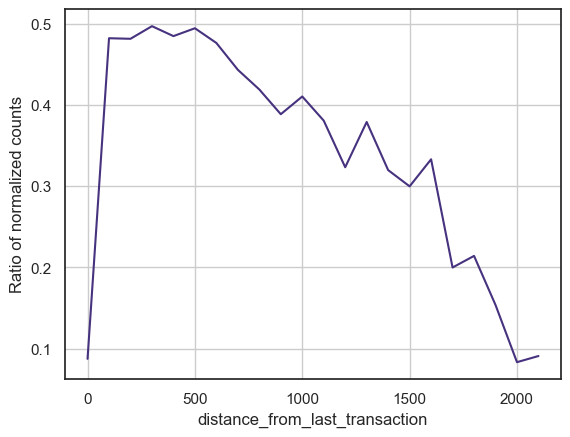

ratio_to_median_purchase_price


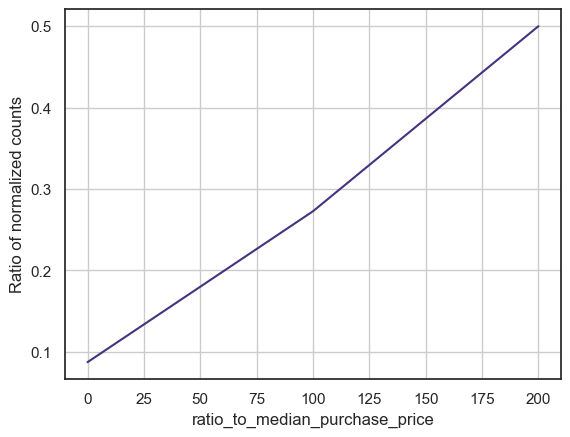

In [7]:
fraud_column_name = 'fraud'
for cols in cols_numerical_features:
    print(cols)
    x_values = []
    y_values = []
    step = 100
    # min_v = df_raw[cols].describe([0.99]).loc['99%']
    min_v = df_raw[cols].describe([0.99]).loc['min']
    max_v = df_raw[cols].describe([0.99]).loc['max']
    higly_distance_fraud_range = range(int(min_v), int(max_v), step)

    for x in higly_distance_fraud_range:
        normalized_counts = df_raw[df_raw[cols] >= x][fraud_column_name].value_counts(normalize=True)
        
        if 0 not in normalized_counts.index:
            ratio = 1
            continue
        elif 1 not in normalized_counts.index:
            ratio = 0
            continue
        else:
            ratio =  normalized_counts.iloc[1]
        
        x_values.append(x)
        y_values.append(ratio)

    # Plotting
    plt.plot(x_values, y_values, label=cols)
    plt.xlabel(cols)
    plt.ylabel('Ratio of normalized counts')
    # plt.legend()
    plt.grid(True)
    plt.show()


## Target


In [9]:
# results are imbalance
labels=["Genuine","Fraud"]

fraud_or_not = df_raw["fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df_raw['fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

In [10]:
target_0 = df_raw['fraud'].value_counts()[0]
target_1 = df_raw['fraud'].value_counts()[1]
target_1/(target_0+target_1), target_0/(target_0+target_1)

(0.087403, 0.912597)

# missing values, duplicate values


In [11]:
df_raw.isnull().sum().sum() # missing values

0

In [12]:
df_raw.duplicated().sum() # duplicated values

0

# Outliers


In [13]:
cols_numerical_features = ["distance_from_home",	"distance_from_last_transaction",	"ratio_to_median_purchase_price"]
cols_bin = ["repeat_retailer",	"used_chip",	"used_pin_number",	"online_order"]

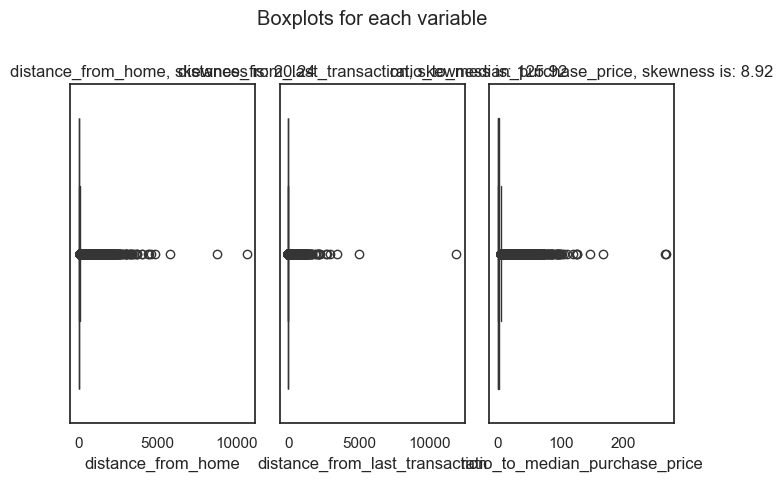

In [14]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True)
    fig.suptitle(suptitle,y=1)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df_raw, columns_list=cols_numerical_features, rows=1, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

## box outlier


In [15]:
NumOfSamples = df_raw.shape[0]
abnormal = pd.DataFrame()
DataNoAbnormal = df_raw.copy()
BoxAbnormalIdx = [] 
for idx,column in enumerate(cols_numerical_features):
    feature = df_raw.loc[:,column]
    QL = np.quantile(feature,0.25)
    QU = np.quantile(feature,0.75)
    IQR = QU - QL
    error = feature[((feature < (QL - 1.5*IQR)).astype(int) + (feature > (QU + 1.5*IQR)).astype(int)) != 0]
    BoxAbnormalIdx.extend(error.index)
    abnormal.loc[idx,"feature"] = column
    abnormal.loc[idx,"OutlierNumber"] = error.shape[0]
    abnormal.loc[idx,"OutlierRate"] = "{:.3f}%".format(error.shape[0]*100/NumOfSamples)

In [16]:
len(set(BoxAbnormalIdx))

281250

In [17]:
(df_raw.loc[BoxAbnormalIdx,"fraud"] != 0).sum() # Among Outliers, the number of fraud 

94780

according to box outliers, there are 281,250, we can either replace those value with mean or mode, but we really need to check whether those outliers can give us more information, such as strong correlated with possibility of "fraud"-target


## 3 sigma


In [18]:
NumOfSamples = df_raw.shape[0]
abnormal = pd.DataFrame()
DataNoAbnormal = df_raw.copy()
SigmaAbnormalIdx = []
for idx,column in enumerate(cols_numerical_features):
    feature = df_raw.loc[:,column]
    mean_ = feature.mean()
    std_ = feature.std()
    error = feature[feature - mean_ > 3*std_]
    SigmaAbnormalIdx.extend(error.index)
    abnormal.loc[idx,"feature"] = column
    abnormal.loc[idx,"OutlierNumber"] = error.shape[0]
    abnormal.loc[idx,"OutlierRate"] = "{:.3f}%".format(error.shape[0]*100/NumOfSamples)

In [19]:
len(set(SigmaAbnormalIdx))

37058

In [20]:
(df_raw.loc[SigmaAbnormalIdx,"fraud"] != 0).sum() # Among Outliers, the number of fraud

20160

In [21]:
(df_raw.loc[:,"fraud"] != 0).sum()

87403

# Feature Engineer


## Bin


according to the performance, using **_bin_** to separate numerical features


## Binary


In [ ]:
cols_numerical_features = ["distance_from_home",	"distance_from_last_transaction",	"ratio_to_median_purchase_price"]
cols_bin = ["repeat_retailer",	"used_chip",	"used_pin_number",	"online_order"]

In [25]:
df = df_raw.copy()
for col in cols_bin:
    df[col] = df[col].astype(int)
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                     int64
used_chip                           int64
used_pin_number                     int64
online_order                        int64
fraud                             float64
dtype: object

In [27]:
# 组合特征

df['chip_and_pin'] = df['used_chip'] & df['used_pin_number']
df['online_order_repeat'] = df['online_order'] & df['repeat_retailer']
df['chip_and_order'] = df['used_chip'] & df['online_order']

# 统计特征
df['num_features_used'] = df[['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']].sum(axis=1)

# 逻辑运算
df['any_feature_used'] = df[['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']].any(axis=1)


# SKEW


In [28]:
len(set(SigmaAbnormalIdx))

37058

In [29]:
sak = pd.DataFrame()
for idx,ColName in enumerate(cols_numerical_features):
    sak.loc[idx,"FeatureName"] = ColName
    column = df.loc[:,ColName]
    sak.loc[idx,"Skew"] = column.skew() 
    sak.loc[idx,"Kurt"] = column.kurt() 
    sak.loc[idx,"Mean"] = column.mean()
sak

,FeatureName,Skew,Kurt,Mean
0,distance_from_home,20.239733,1471.615654,26.628792
1,distance_from_last_transaction,125.921226,46979.271728,5.036519
2,ratio_to_median_purchase_price,8.915015,289.503307,1.824182


# Feature Correlation


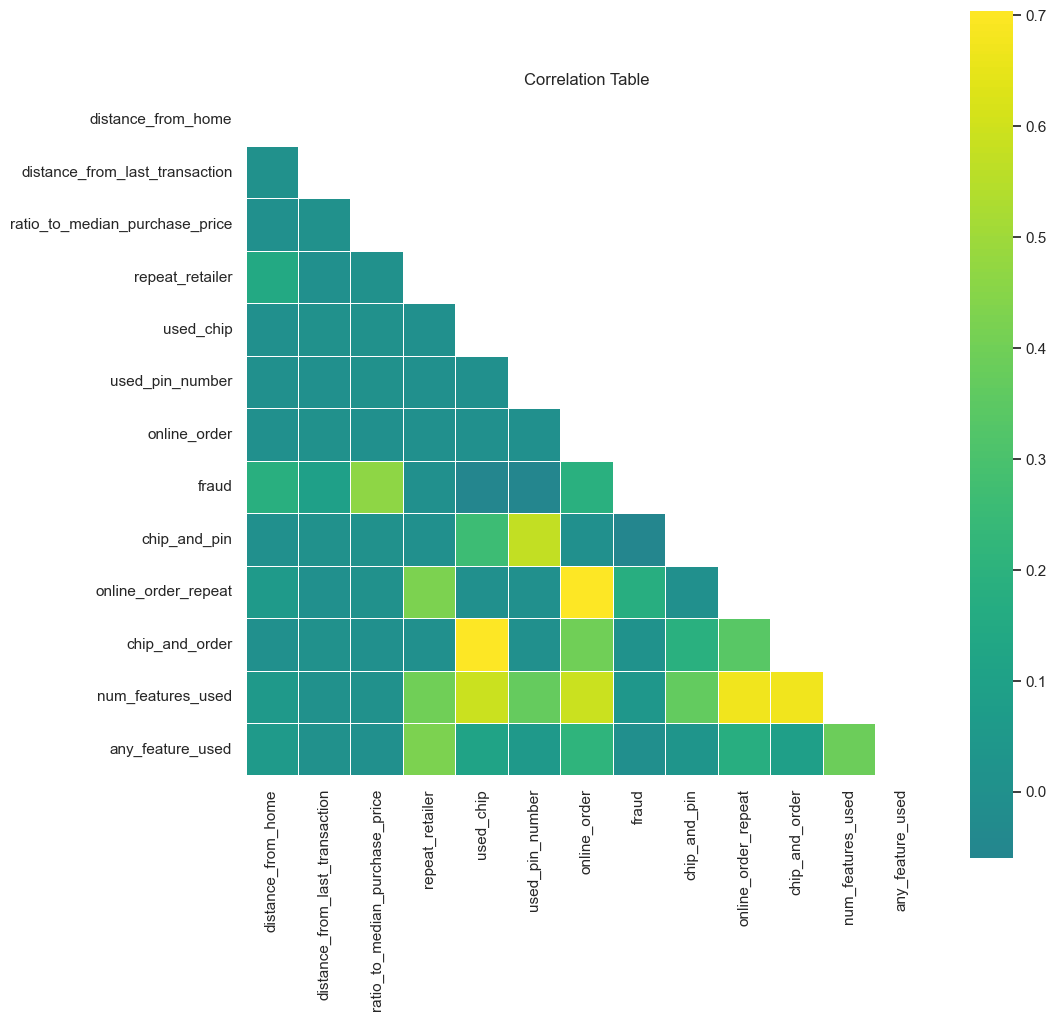

In [30]:
plt.figure(figsize = (11,11))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, cmap="viridis",linewidths = .6)
plt.title('Correlation Table')
plt.show()


<Figure size 1000x1000 with 0 Axes>

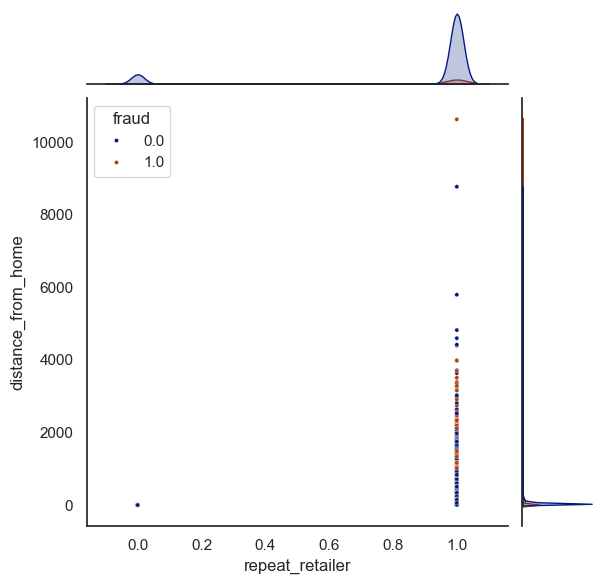

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(x="repeat_retailer", y='distance_from_home',hue='fraud', data=df, palette='dark', s=9)

<Figure size 1000x1000 with 0 Axes>

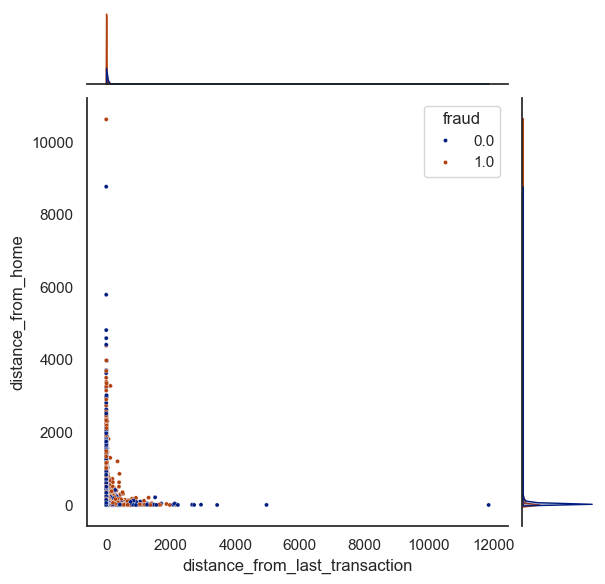

In [31]:
plt.figure(figsize=(10,10))
sns.jointplot(x="distance_from_last_transaction", y='distance_from_home',hue='fraud', data=df, palette='dark', s=9)

<Figure size 1000x1000 with 0 Axes>

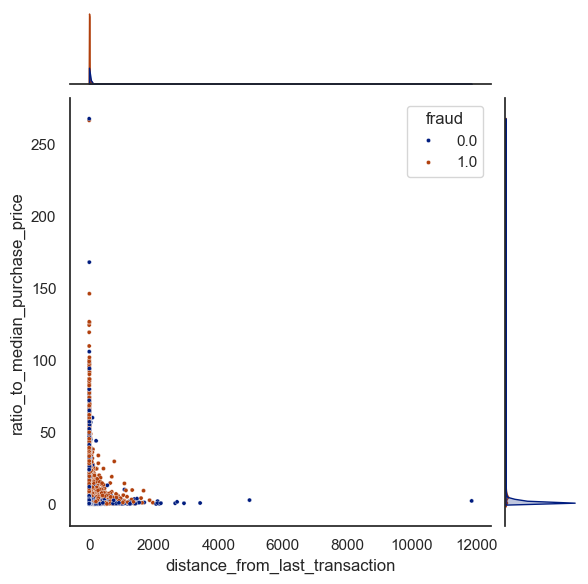

In [ ]:
plt.figure(figsize=(10,10))
sns.jointplot(x="distance_from_last_transaction", y='ratio_to_median_purchase_price',hue='fraud', data=df, palette='dark', s=9)

<Figure size 1000x1000 with 0 Axes>

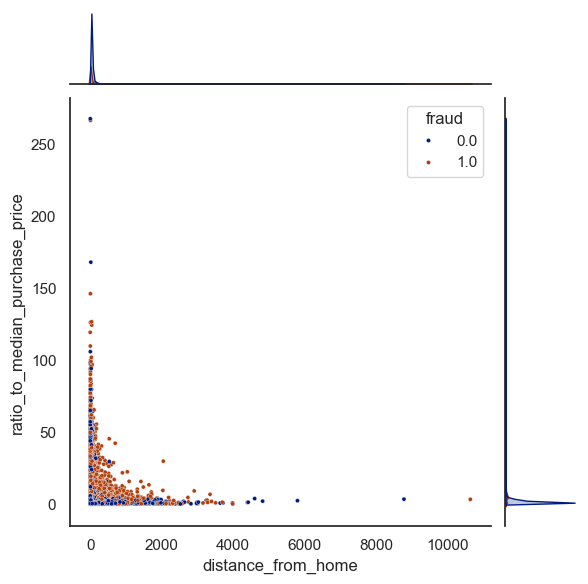

In [32]:
plt.figure(figsize=(10,10))
sns.jointplot(x="distance_from_home", y='ratio_to_median_purchase_price',hue='fraud', data=df, palette='dark', s=9)

In [33]:
cols_numerical_features = ["distance_from_home",	"distance_from_last_transaction",	"ratio_to_median_purchase_price"]
cols_bin = ["repeat_retailer",	"used_chip",	"used_pin_number",	"online_order"]

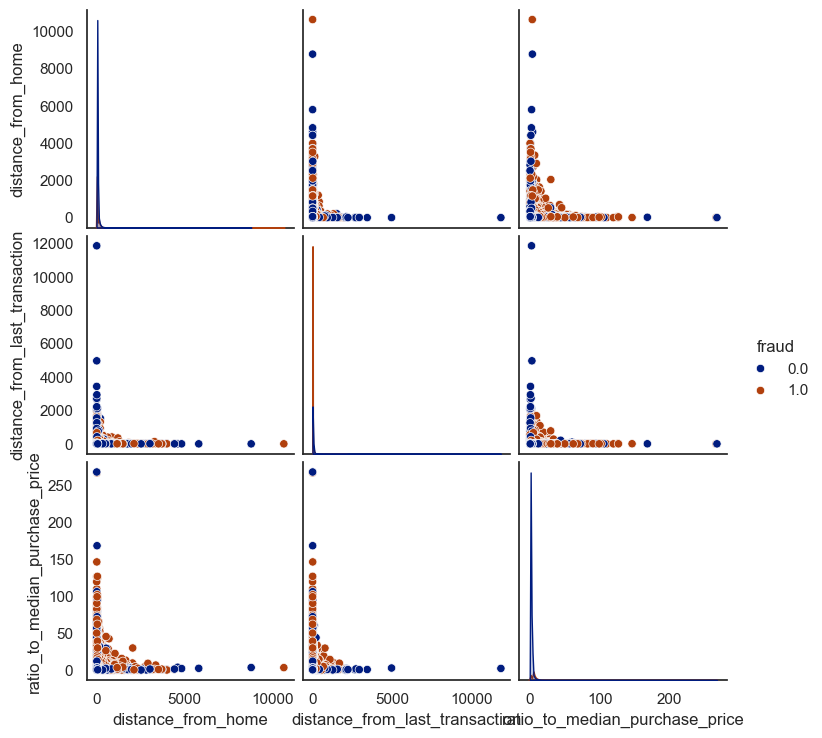

In [34]:
sns.pairplot(data=df[cols_numerical_features+['fraud']], hue = 'fraud', palette='dark')
plt.show()

# Baseline Model


## Train-Test Split


ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

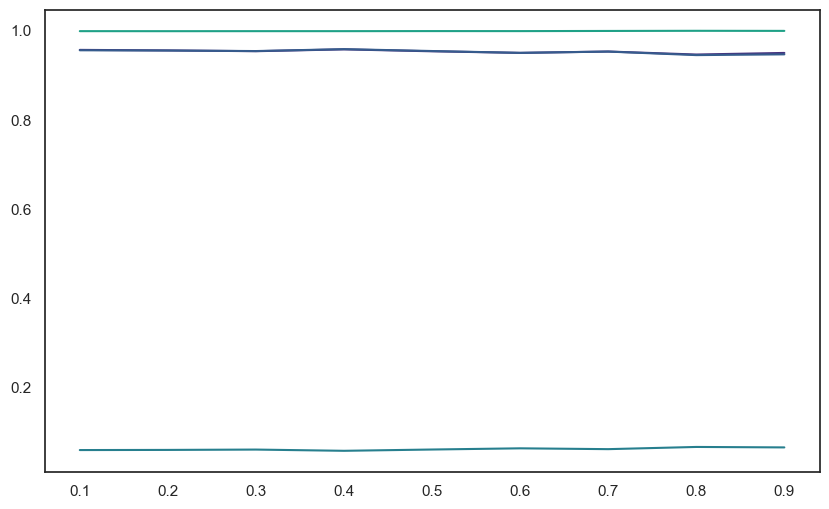

In [ ]:
def train_func(data):


    X = df.drop('fraud', axis=1)
    y = df['fraud']
    X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.4, random_state=0)

    train_r2 = []
    test_r2 = []
    test_RMSE = []
    test_ROC = []
    test_Precision = []
    test_Recall = []

    
    def find_test_size():
        test_sizes = np.arange(0.1, 1.0, 0.1)
        for test_size in test_sizes:
            X_train, X_test, y_train, y_test = TTS(X, y, test_size=test_size, random_state=0)
            model = GBR().fit(X_train, y_train)
            train_r2.append(model.score(X_train, y_train))
            test_r2.append(model.score(X_test, y_test))
            test_RMSE.append(np.sqrt(MSE(y_test, model.predict(X_test))))
            test_ROC.append(np.sqrt(ROC(y_test, model.predict(X_test))))
        # R2
        plt.plot(test_sizes, train_r2, label='Train R^2')
        plt.plot(test_sizes, test_r2, label='Test R^2')
        plt.xlabel('Test Size')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.title('Model Performance vs. Test Size')
        plt.legend()
        plt.show()

        # RMSE
        plt.figure(figsize=(10, 6))
        plt.plot(test_sizes, test_RMSE, label='Test RMSE')
        plt.xlabel('Test Size')
        plt.ylabel('Metric Value')
        plt.title('Model Performance vs. Test Size')
        plt.legend()
        plt.show()

        # ROC
        plt.plot(test_sizes, test_ROC, label='Test ROC')
        plt.xlabel('Test Size')
        plt.ylabel('Metric Value')
        plt.title('Model Performance vs. Test Size')
        plt.legend()
        plt.grid(True)
        plt.show()


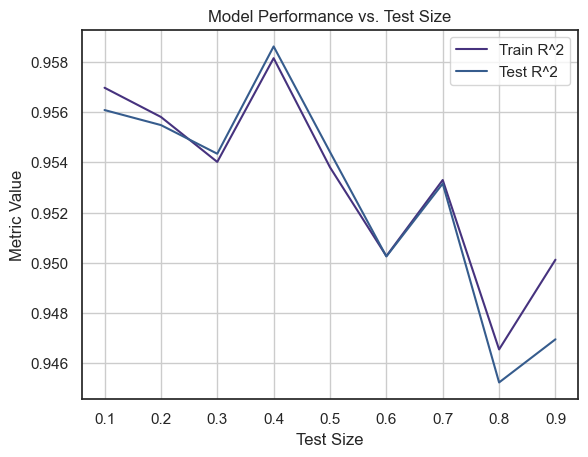

In [ ]:
# Plotting

plt.plot(test_sizes, train_r2, label='Train R^2')
plt.plot(test_sizes, test_r2, label='Test R^2')

plt.xlabel('Test Size')
plt.ylabel('Metric Value')
plt.grid(True)
plt.title('Model Performance vs. Test Size')
plt.legend()
plt.show()

From above fig, we can see when test size=0.4, it reaches at its peak, though with overfitting


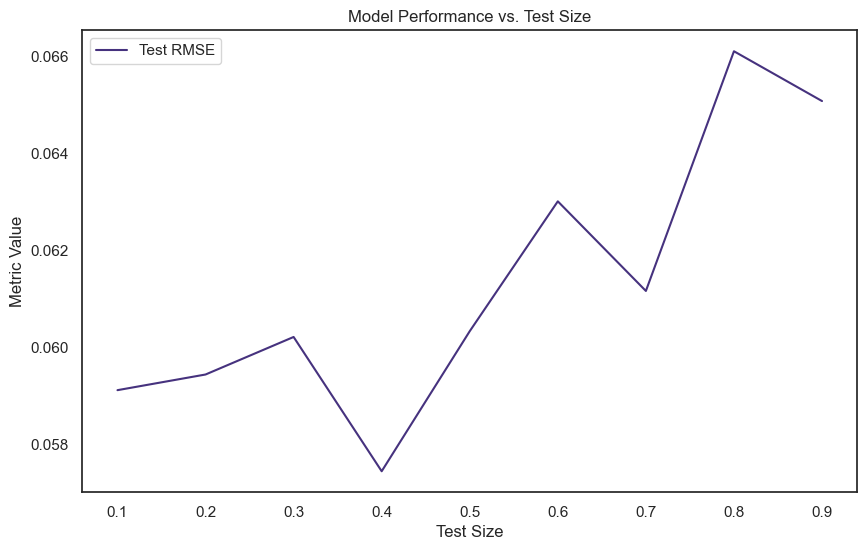

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, test_RMSE, label='Test RMSE')

plt.xlabel('Test Size')
plt.ylabel('Metric Value')
plt.title('Model Performance vs. Test Size')
plt.legend()
plt.show()

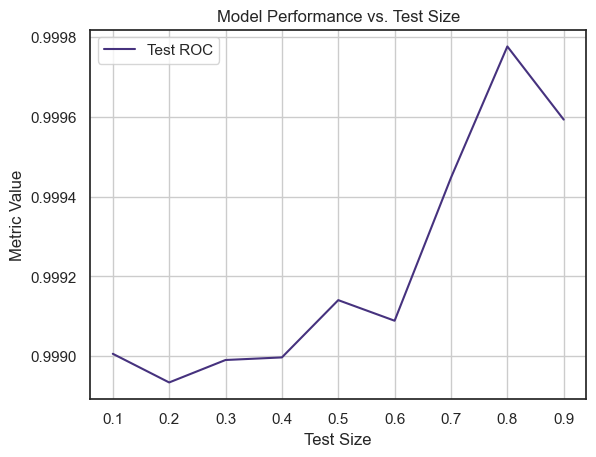

In [ ]:
plt.plot(test_sizes,test_ROC, label='Test ROC')
plt.xlabel('Test Size')
plt.ylabel('Metric Value')
plt.title('Model Performance vs. Test Size')
plt.legend()
plt.grid(True)
plt.show()

this is very strange, why test roc reaches its summit at 0.8


# Train


In [ ]:
def train(df, model_filename, reg=False):
    X = df.drop('fraud', axis=1)
    y = df['fraud']
    X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.4, random_state=0)
    
    if reg:
        model = GBR().fit(X_train, y_train)
        prob = model.predict(X_test)
        pred = (prob >= 0.5).astype(int)
        draw_confusion(y_test, pred)
        draw_ROC(y_test, prob)
    else:
        model = GBC().fit(X_train, y_train)
        pred = model.predict(X_test)
        draw_confusion(y_test, pred)
        y_scores = model.predict_proba(X_test)[:, 1]
        draw_ROC(y_test, y_scores)
    
    joblib.dump(model, model_filename)
    
    print("Model saved to", model_filename)
    print("Classification Report:")
    print(classification_report(y_test, pred))


In [ ]:
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.4, random_state=0)

In [ ]:
model = GBR().fit(X_train, y_train)

In [ ]:
model.predict(X_test)

array([9.84544826e-01, 8.21544883e-03, 8.21544883e-03, ...,
       9.52582374e-04, 8.88482092e-01, 3.51459451e-03])

In [ ]:
prob = model.predict(X_test).tolist()
max(prob), min(prob)

(2.4797590925333783, -0.2933407786160514)

In [ ]:
recall_list = []
precision_list = []
for tol in np.linspace(-0.3,2.5,200):
    pred = (prob >= tol).astype(int)
    recall = Recall(y_test,pred)
    precision = Precision(y_test,pred)
    recall_list.append(recall)
    precision_list.append(precision)

/Users/yangen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yangen/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x = np.linspace(-0.3,2.5,200)
x

array([-0.3       , -0.28592965, -0.2718593 , -0.25778894, -0.24371859,
       -0.22964824, -0.21557789, -0.20150754, -0.18743719, -0.17336683,
       -0.15929648, -0.14522613, -0.13115578, -0.11708543, -0.10301508,
       -0.08894472, -0.07487437, -0.06080402, -0.04673367, -0.03266332,
       -0.01859296, -0.00452261,  0.00954774,  0.02361809,  0.03768844,
        0.05175879,  0.06582915,  0.0798995 ,  0.09396985,  0.1080402 ,
        0.12211055,  0.1361809 ,  0.15025126,  0.16432161,  0.17839196,
        0.19246231,  0.20653266,  0.22060302,  0.23467337,  0.24874372,
        0.26281407,  0.27688442,  0.29095477,  0.30502513,  0.31909548,
        0.33316583,  0.34723618,  0.36130653,  0.37537688,  0.38944724,
        0.40351759,  0.41758794,  0.43165829,  0.44572864,  0.45979899,
        0.47386935,  0.4879397 ,  0.50201005,  0.5160804 ,  0.53015075,
        0.54422111,  0.55829146,  0.57236181,  0.58643216,  0.60050251,
        0.61457286,  0.62864322,  0.64271357,  0.65678392,  0.67

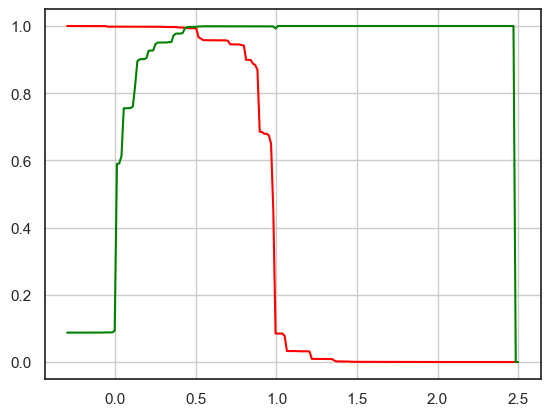

In [ ]:
plt.plot(x, recall_list, label='recall', color = 'red')
plt.plot(x, precision_list, label='precision', color = 'green' )
plt.grid(True)

# Baseline Result


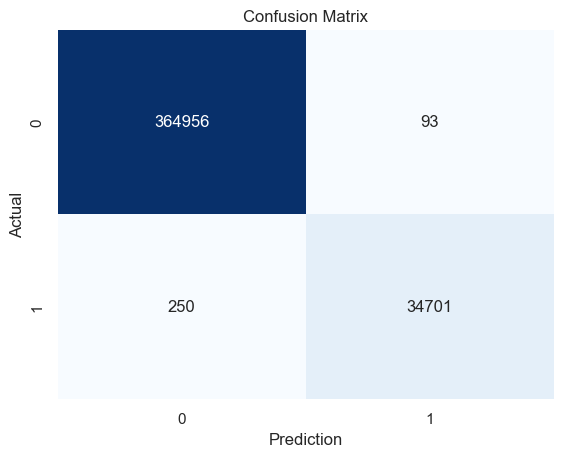

In [ ]:
prob_ = np.array(prob)
pred = (prob_ >= 0.5).astype(int)
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
ROC(y_test, pred)

0.9962961842588339

# feature engineer


distance_from_home
100
1500
1600
3400
5800


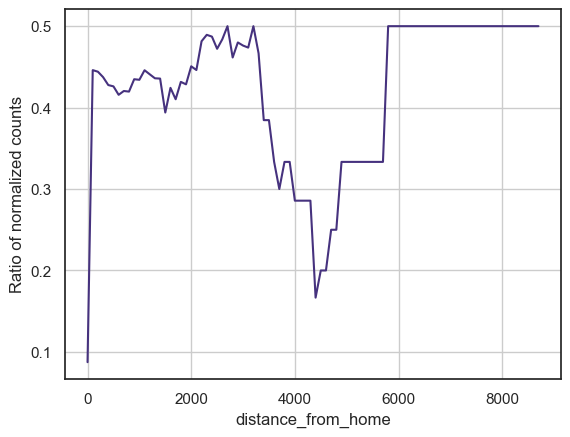

distance_from_last_transaction
100
900
1000
1100


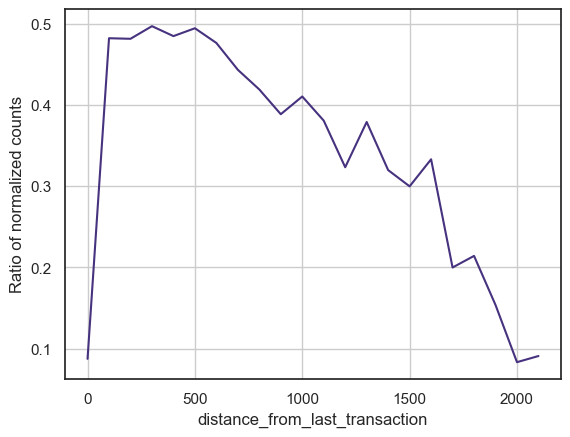

ratio_to_median_purchase_price
200


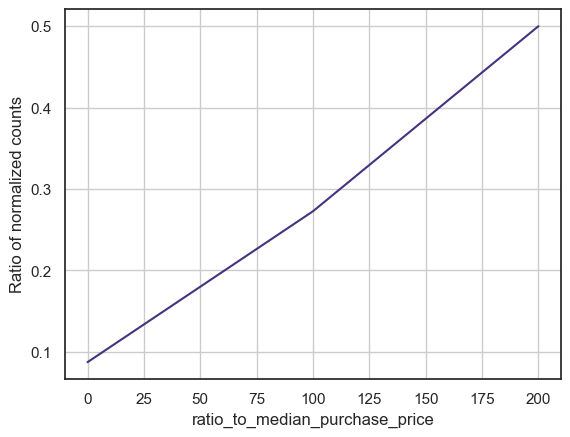

In [25]:
fraud_column_name = 'fraud'
for cols in cols_numerical_features:
    print('======================================')
    print(cols)
    x_values = []
    y_values = []
    step = 100
    # min_v = df[cols].describe([0.99]).loc['99%']
    min_v = df[cols].describe([0.99]).loc['min']
    max_v = df[cols].describe([0.99]).loc['max']
    higly_distance_fraud_range = range(int(min_v), int(max_v), step)

    for x in higly_distance_fraud_range:
        normalized_counts = df[df[cols] >= x][fraud_column_name].value_counts(normalize=True)
        
        if 0 not in normalized_counts.index:
            ratio = 1
            continue
        elif 1 not in normalized_counts.index:
            ratio = 0
            continue
        else:
            ratio =  normalized_counts.iloc[1]
        if (len(y_values) > 0 and ratio >= 0.4 and y_values[-1] < 0.4) or (len(y_values) > 0 and ratio <= 0.4 and y_values[-1] > 0.4):
            print(x)


        x_values.append(x)
        y_values.append(ratio)
        

    # Plotting
    plt.plot(x_values, y_values, label=cols)
    plt.xlabel(cols)
    plt.ylabel('Ratio of normalized counts')
    # plt.legend()
    plt.grid(True)
    plt.show()


In [59]:
df['distance_from_home_bin'] = pd.cut(
    df['distance_from_home'],
    bins=[df['distance_from_home'].min(), 100, 3400, 5800, df['distance_from_home'].max()+1],
    labels=[0, 1, 0,1],
    right=False,
    ordered=False  # Set to False to allow duplicate labels
)


In [60]:
df['distance_from_home_bin'].value_counts() # it will cause overfitting if in real scenerio

distance_from_home_bin
0    950222
1     49778
Name: count, dtype: int64

In [55]:
df['distance_from_last_transaction_bin'] = pd.cut(
    df['distance_from_last_transaction'],
    bins=[df['distance_from_last_transaction'].min(), 100, 900, df['distance_from_last_transaction'].max()+1],
    labels=[0, 1, 0],
    right=False,
    ordered=False  # Set to False to allow duplicate labels
)

In [56]:
df['distance_from_last_transaction_bin'].value_counts()

distance_from_last_transaction_bin
0    994812
1      5188
Name: count, dtype: int64

In [57]:
df['ratio_to_median_purchase_price_bin'] = pd.cut(
    df['ratio_to_median_purchase_price'],
    bins=[df['ratio_to_median_purchase_price'].min(), 200, df['ratio_to_median_purchase_price'].max()+1],
    labels=[0, 1],
    right=False,
    ordered=False  # Set to False to allow duplicate labels
)

In [58]:
df['ratio_to_median_purchase_price_bin'].value_counts()

ratio_to_median_purchase_price_bin
0    999998
1         2
Name: count, dtype: int64

In [61]:
df


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,distance_from_home_bin,distance_from_last_transaction_bin,ratio_to_median_purchase_price_bin
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0,0,0,0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0,0,0,0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0,0,0,0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0,0,0,0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0,0,0,0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0,0,0,0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0,0,0,0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0,0,0,0


In [62]:
df.to_csv('train_bin.csv')

In [3]:
features = pd.read_csv('features.csv')
df = pd.read_csv('card_transdata.csv')

In [5]:
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [6]:
features

,Unnamed: 0,chip_and_pin,chip_and_order,chip_and_retailer,order_and_retailer,pin_and_retailer,pin_and_order,num_features_used,any_feature_used,cartesian_product,distance_from_home_bin,distance_from_last_transaction_bin,ratio_to_median_purchase_price_bin,home_and_transaction_bin,home_and_median_bin,transaction_and_median_bin,num_features_used_bin,any_feature_used_bin
0,0,0,0,1,0,0,0,2,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,1,"(0.0, 1.0)",0,0,0,0,0,0,0,0
2,2,0,0,0,1,0,1,2,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
3,3,0,1,1,1,0,1,3,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
4,4,0,1,1,1,0,1,3,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,0,0,1,0,0,0,2,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
999996,999996,0,0,1,0,0,0,2,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
999997,999997,0,1,1,1,0,1,3,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
999998,999998,0,0,0,1,0,1,2,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0


In [45]:
concatenated_df = pd.read_csv('concatenated_file.csv')
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df.drop("Unnamed: 0", axis=1, inplace=True)
concatenated_df.to_csv('concatenated_file.csv')

In [56]:
concatenated_df.dtypes

distance_from_home                    float64
distance_from_last_transaction        float64
ratio_to_median_purchase_price        float64
repeat_retailer                       float64
used_chip                             float64
used_pin_number                       float64
online_order                          float64
fraud                                 float64
chip_and_pin                            int64
chip_and_order                          int64
chip_and_retailer                       int64
order_and_retailer                      int64
pin_and_retailer                        int64
pin_and_order                           int64
num_features_used                       int64
any_feature_used                        int64
cartesian_product                      object
distance_from_home_bin                  int64
distance_from_last_transaction_bin      int64
ratio_to_median_purchase_price_bin      int64
home_and_transaction_bin                int64
home_and_median_bin               

In [57]:

label_encoder = LabelEncoder()
concatenated_df['cartesian_product'] = label_encoder.fit_transform(concatenated_df['cartesian_product'])

In [7]:
# Concatenate along columns (joining DataFrames horizontally)
concatenated_df = pd.concat([df, features], axis=1)

# Save the concatenated DataFrame to a new CSV file
concatenated_df.to_csv('concatenated_file.csv', index=False)


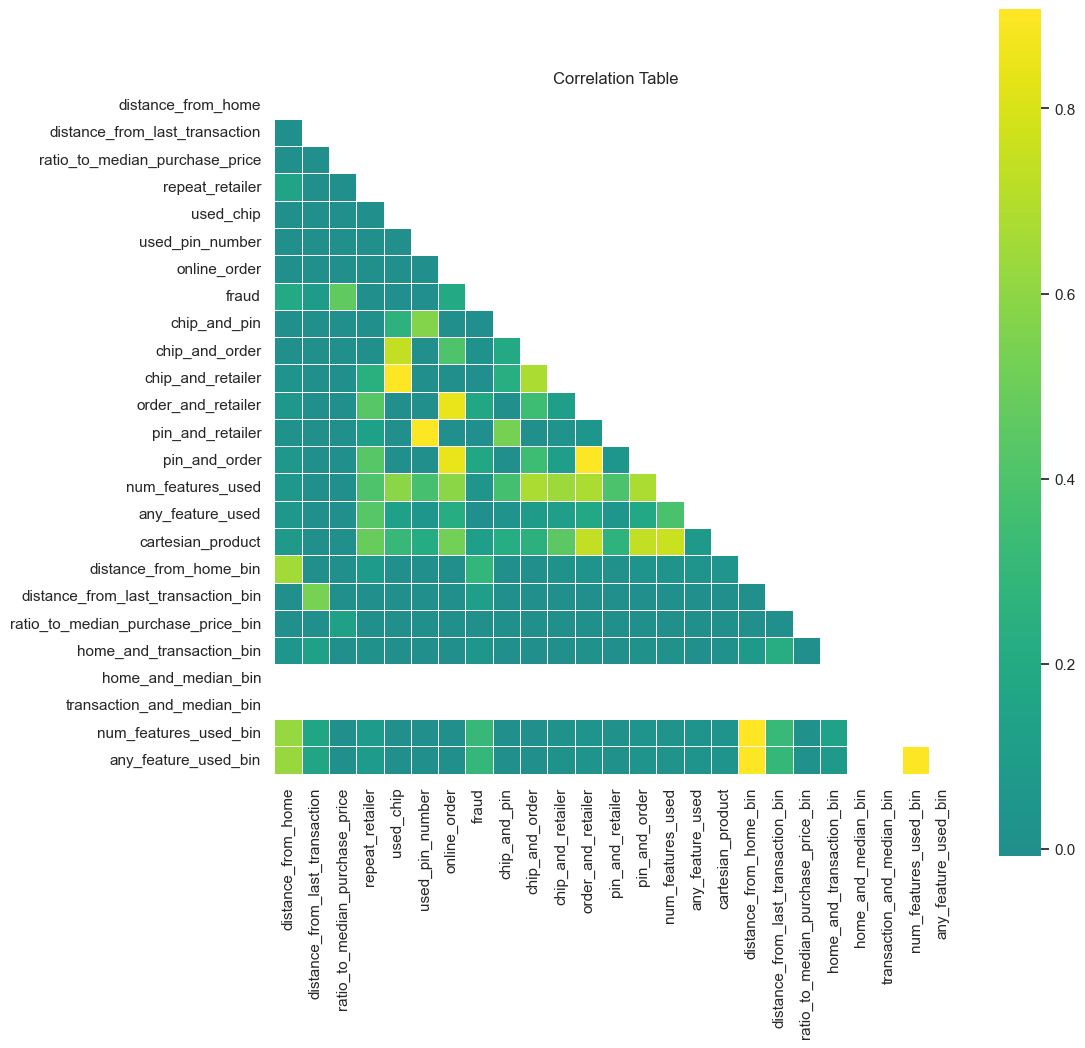

In [59]:
plt.figure(figsize = (11,11))
corr = concatenated_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, cmap="viridis",linewidths = .6)
plt.title('Correlation Table')
plt.show()


In [34]:
# Create a mapping dictionary
mapping = {(1.0, 0.0): 3, (0.0, 1.0): 2, (0.0,): 0, (1.0,): 1}
concatenated_df.reset_index(drop=True, inplace=True)
# Map the values in 'cartesian_product' to integers
concatenated_df['cartesian_product_mapped'] = concatenated_df['cartesian_product'].apply(lambda x: mapping.get(x, None))
concatenated_df.reset_index(drop=True, inplace=True)

In [42]:
concatenated_df.astype(str)

,level_0,index,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,...,cartesian_product,distance_from_home_bin,distance_from_last_transaction_bin,ratio_to_median_purchase_price_bin,home_and_transaction_bin,home_and_median_bin,transaction_and_median_bin,num_features_used_bin,any_feature_used_bin,cartesian_product_mapped
0,0,0,57.87785658389723,0.3111400080477545,1.9459399775518595,1.0,1.0,0.0,0.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
1,1,1,10.829942699255543,0.1755915022816658,1.294218810619857,1.0,0.0,0.0,0.0,0.0,...,"(0.0, 1.0)",0,0,0,0,0,0,0,0,None
2,2,2,5.091079490616996,0.8051525945853258,0.4277145611942758,1.0,0.0,0.0,1.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
3,3,3,2.2475643282963613,5.60004354707232,0.3626625780570958,1.0,1.0,0.0,1.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
4,4,4,44.19093600261837,0.5664862680583477,2.2227672978404707,1.0,1.0,0.0,1.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,999995,2.2071007085956595,0.1126513027947371,1.6267975897996456,1.0,1.0,0.0,0.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
999996,999996,999996,19.872725762075127,2.6839037264517254,2.778302935930713,1.0,1.0,0.0,0.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
999997,999997,999997,2.914856986796768,1.4726866870566833,0.2180754860145264,1.0,1.0,0.0,1.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None
999998,999998,999998,4.258729391720518,0.2420233659455144,0.4758220644483312,1.0,0.0,0.0,1.0,0.0,...,"(1.0, 0.0)",0,0,0,0,0,0,0,0,None


In [35]:
concatenated_df.dtypes

level_0                                 int64
index                                   int64
distance_from_home                    float64
distance_from_last_transaction        float64
ratio_to_median_purchase_price        float64
repeat_retailer                       float64
used_chip                             float64
used_pin_number                       float64
online_order                          float64
fraud                                 float64
chip_and_pin                            int64
chip_and_order                          int64
chip_and_retailer                       int64
order_and_retailer                      int64
pin_and_retailer                        int64
pin_and_order                           int64
num_features_used                       int64
any_feature_used                        int64
cartesian_product                      object
distance_from_home_bin                  int64
distance_from_last_transaction_bin      int64
ratio_to_median_purchase_price_bin

In [60]:
X = concatenated_df.drop('fraud', axis=1)
y = concatenated_df['fraud']

In [18]:
X

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,chip_and_pin,chip_and_order,chip_and_retailer,...,any_feature_used,cartesian_product,distance_from_home_bin,distance_from_last_transaction_bin,ratio_to_median_purchase_price_bin,home_and_transaction_bin,home_and_median_bin,transaction_and_median_bin,num_features_used_bin,any_feature_used_bin
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0,0,1,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0,0,0,...,1,"(0.0, 1.0)",0,0,0,0,0,0,0,0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0,0,0,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0,1,1,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0,1,1,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0,0,1,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0,0,1,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0,1,1,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0,0,0,...,1,"(1.0, 0.0)",0,0,0,0,0,0,0,0


In [61]:
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.4, random_state=0)

In [62]:
model = GBR().fit(X_train, y_train)

In [63]:
model = GBR().fit(X_train, y_train)
prob = model.predict(X_test).tolist()
max(prob), min(prob)
prob_ = np.array(prob)
pred = (prob_ >= 0.5).astype(int)
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

(1.6752378354524757, -0.3336019909550475)

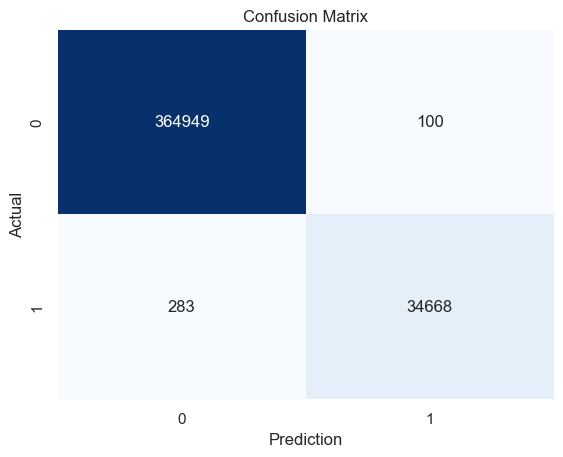

In [64]:
prob_ = np.array(prob)
pred = (prob_ >= 0.5).astype(int)
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

In [65]:
ROC(y_test, pred)

0.9958145070081372

In [70]:
concatenated_df.to_csv('concatenated_file.csv')

In [71]:
model.feature_importances_

array([6.32435075e-03, 2.68386737e-02, 4.36543967e-01, 0.00000000e+00,
       3.21611362e-04, 7.16020507e-02, 2.35948644e-01, 1.69795879e-05,
       4.33948067e-04, 1.71664471e-02, 1.05958771e-04, 3.61102863e-05,
       1.44381968e-04, 6.82658255e-02, 1.55503507e-02, 5.15448552e-04,
       1.75996673e-03, 3.34307983e-05, 0.00000000e+00, 6.65407786e-04,
       0.00000000e+00, 0.00000000e+00, 7.44170639e-02, 4.33093829e-02])

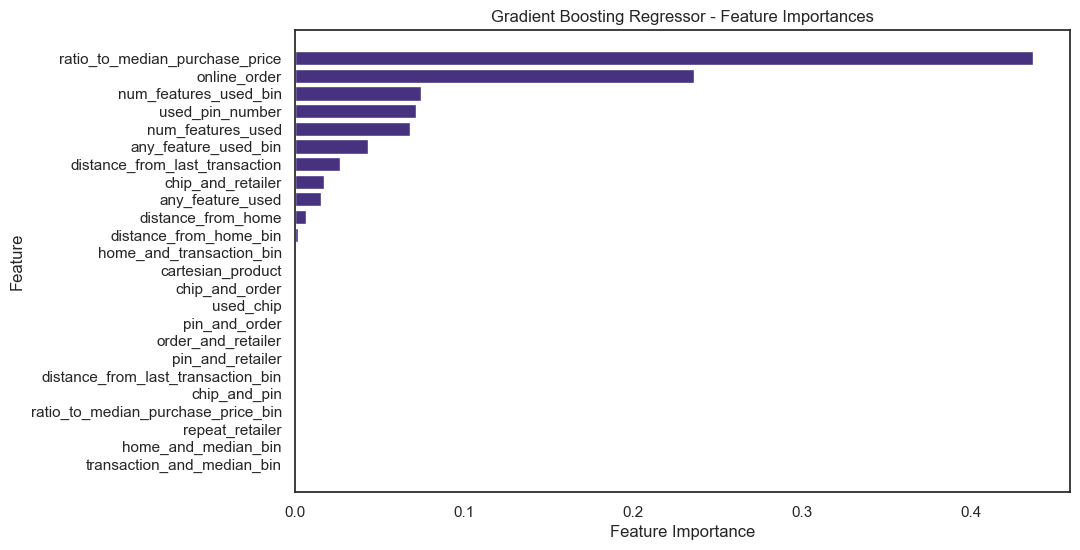

In [72]:
# Get feature importances
feature_importances = model.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort indices based on feature importances
sorted_indices = np.argsort(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices])
plt.yticks(range(len(feature_importances)), feature_names[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Regressor - Feature Importances')
plt.show()

In [74]:
drop_cols = ['home_and_transaction_bin','cartesian_product' , 'chip_and_order','used_chip','pin_and_order','order_and_retailer', 'pin_and_retailer','distance_from_last_transaction_bin','chip_and_pin','ratio_to_median_purchase_price_bin','repeat_retailer','home_and_median_bin','transaction_and_median_bin']
concatenated_drop = concatenated_df.drop(drop_cols, axis=1)
concatenated_drop

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,used_pin_number,online_order,fraud,chip_and_retailer,num_features_used,any_feature_used,distance_from_home_bin,num_features_used_bin,any_feature_used_bin
0,57.877857,0.311140,1.945940,0.0,0.0,0.0,1,2,1,0,0,0
1,10.829943,0.175592,1.294219,0.0,0.0,0.0,0,1,1,0,0,0
2,5.091079,0.805153,0.427715,0.0,1.0,0.0,0,2,1,0,0,0
3,2.247564,5.600044,0.362663,0.0,1.0,0.0,1,3,1,0,0,0
4,44.190936,0.566486,2.222767,0.0,1.0,0.0,1,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,0.0,0.0,0.0,1,2,1,0,0,0
999996,19.872726,2.683904,2.778303,0.0,0.0,0.0,1,2,1,0,0,0
999997,2.914857,1.472687,0.218075,0.0,1.0,0.0,1,3,1,0,0,0
999998,4.258729,0.242023,0.475822,0.0,1.0,0.0,0,2,1,0,0,0


In [73]:
concatenated_df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud', 'chip_and_pin',
       'chip_and_order', 'chip_and_retailer', 'order_and_retailer',
       'pin_and_retailer', 'pin_and_order', 'num_features_used',
       'any_feature_used', 'cartesian_product', 'distance_from_home_bin',
       'distance_from_last_transaction_bin',
       'ratio_to_median_purchase_price_bin', 'home_and_transaction_bin',
       'home_and_median_bin', 'transaction_and_median_bin',
       'num_features_used_bin', 'any_feature_used_bin'],
      dtype='object')

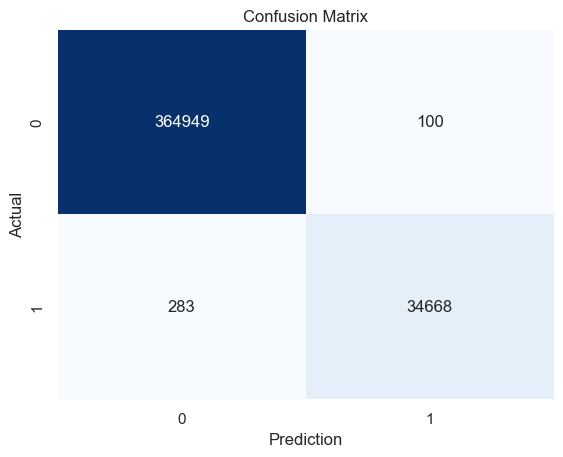

0.9958145070081372

In [75]:
model = GBR().fit(X_train, y_train)
prob = model.predict(X_test).tolist()
max(prob), min(prob)
prob_ = np.array(prob)
pred = (prob_ >= 0.5).astype(int)
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
ROC(y_test, pred)

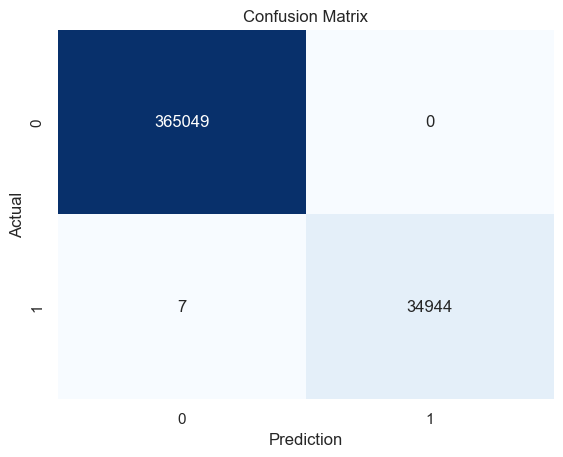

0.9998998598037252

In [78]:
model = GBC().fit(X_train, y_train)
pred = model.predict(X_test).tolist()
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
ROC(y_test, pred)

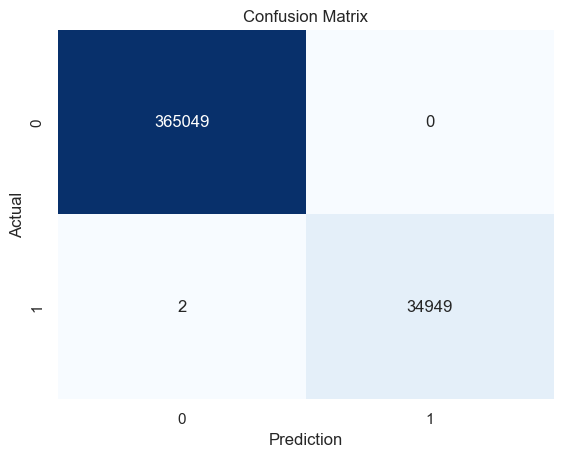

0.9999713885153501

In [79]:
X = concatenated_drop.drop('fraud', axis=1)
y = concatenated_drop['fraud']
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.4, random_state=0)
model = GBC().fit(X_train, y_train)
pred = model.predict(X_test).tolist()
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
ROC(y_test, pred)

In [81]:
concatenated_drop.to_csv('features_imp.csv')

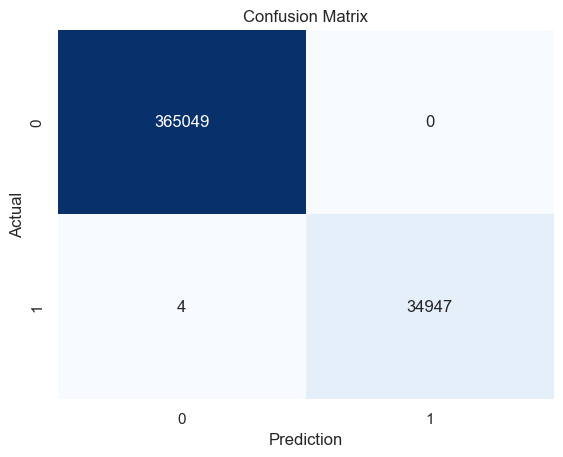

0.9999427770307001

In [80]:
df = pd.read_csv('card_transdata.csv')
X = df.drop('fraud', axis=1)
y = df['fraud']
X_train, X_test, y_train, y_test = TTS(X, y, test_size=0.4, random_state=0)
model = GBC().fit(X_train, y_train)
pred = model.predict(X_test).tolist()
c_matrix = confusion_matrix(y_test,pred)
ax = sns.heatmap(c_matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()
ROC(y_test, pred)